In [1]:
import numpy as np 
from astropy.io import fits 
from astropy.convolution import Gaussian1DKernel, convolve
from matplotlib import pylab as plt
from astropy.stats import sigma_clip
import pandas as pd
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
import os
from scipy.ndimage import median_filter
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit


In [2]:
#constants
redshift = 0.039853398
gain = 1.2 #e/ADU
readnoise = 5 #e

#slit width is 2.5
exposure_time_standard = 80 #sec
exposure_time_science = 2700 #sec 

airmass_standard = 1.02
airmass_science = 1.49 + 1.4 + 1.35 / 3

### functions

In [3]:
def load_average(file_list, unit=u.adu, ext=1):
    """Load selected FITS files, average them, and return a CCDData object."""
    data_list = [fits.getdata(f, ext=ext) for f in file_list]
    mean_data = np.mean(data_list, axis=0)
    return CCDData(mean_data, unit=unit)

def load_sum(file_list, unit=u.adu, ext=1):
    """Load selected FITS files, sum them, and return a CCDData object."""
    data_list = [fits.getdata(f, ext=ext) for f in file_list]
    summed_data = np.sum(data_list, axis=0)
    return CCDData(summed_data, unit=unit)


In [4]:
def plot_ccd_and_spectrum(data, window=[-5,5], figsize=(14,6), perc=5,
                          stdev=10, sigma_clipping=5, plot_smooth=True,
                          xlims_override=[], ylims_override=[], 
                          axvlines_spectrum=[], axvlines_ccd=[],
                          xlab='Wavelength [pix]', ylab='Signal', title=''):

    data = np.array(data)
    lam, slit = data.shape    
    mid = slit/2

    # Setup subplot
    fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1, 2]})

    # --- Left: 2D CCD plot
    axs[0].imshow(data, 
                  cmap='Spectral', 
                  origin='lower', 
                  aspect='auto',
                  vmin=np.nanpercentile(data, perc), 
                  vmax=np.nanpercentile(data, 100 - perc))
    axs[0].set_title("2D CCD Image")
    axs[0].set_xlabel('Position along slit [pix]')
    axs[0].set_ylabel('Wavelength [pix]')
    plt.colorbar(axs[0].images[0], ax=axs[0], fraction=0.046, pad=0.04)

    for axv in axvlines_ccd:
        axs[0].axvline(mid+axv, color='black', linestyle='-', lw=1)

    # --- Right: Extracted 1D Spectrum
    if len(data.shape) > 1:
        spectrum = extract_spectrum(data, window)
        xaxis = range(data.shape[0])[::-1]
    else:
        spectrum = data
        xaxis = range(len(data))[::-1]

    if isinstance(sigma_clipping, int):
        spectrum_clipped = sigma_clip(spectrum, sigma=sigma_clipping, maxiters=1)
    else:
        spectrum_clipped = spectrum
    smoothed = convolve(spectrum_clipped, Gaussian1DKernel(stddev=stdev))

    axs[1].plot(xaxis, spectrum_clipped, color='black', label='Raw')
    if plot_smooth:
        axs[1].plot(xaxis, smoothed, color='red', label='Smoothed')
    
    axs[1].set_xlabel(xlab)
    axs[1].set_ylabel(ylab)
    axs[1].set_title(title or "Extracted Spectrum")
    axs[1].legend()

    if ylims_override:
        axs[1].set_ylim(*ylims_override)
    else:
        axs[1].set_ylim(np.nanpercentile(spectrum_clipped, 1),
                        np.nanpercentile(spectrum_clipped, 100))

    if xlims_override:
        axs[1].set_xlim(*xlims_override)

    for axv in axvlines_spectrum:
        axs[1].axvline(axv, color='r', linestyle='--', lw=1)

    plt.tight_layout()
    plt.show()


In [5]:
def plot_ccd(data,figsize = (7,12), perc = 5, axvlines = [], title = 'Raw data', vmin = None, vmax = None):
    data = np.array(data)
    lam,slit = data.shape
    mid = slit/2

    if vmin == None:
        vmin = np.nanpercentile(data,perc)
    if vmax == None:
        vmax = np.nanpercentile(data,100-perc)
        
    plt.figure(figsize = figsize)

    plt.pcolormesh(data, vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.ylabel('Wavelength [pix]')
    plt.xlabel('Position along slit [pix]')
    plt.title(title)
    
    for axv in axvlines:
        plt.axvline(mid+axv, c='r', lw = 1)

    plt.show()

In [6]:
def plot_estimated_spectrum(data,window = [-5,5],ylims_override = [],xlims_override = [], stdev = 10,
                            axvlines = [], figsize = (12,5), plot_smooth = True, sigma_clipping = 5, 
                            xaxis = [],xlab = 'Wavelength [pix]', ylab = 'Signal', title = '',
                           savefig = ''):
    data = np.array(data)
    
    if len(data.shape) > 1:
        gal = extract_spectrum(data,window)
        if xaxis == []:
            lam,slit = data.shape
            xaxis = range(lam)[::-1]
    else: #means spectrum already extracted
        gal = data
        if xaxis == []:
            xaxis = range(len(data))[::-1]
    
    if type(sigma_clipping) == int:
        galclip = sigma_clip(gal, sigma=sigma_clipping, maxiters=1, cenfunc=np.nanmean, stdfunc=np.nanstd, masked=True) # Smooth the spectrum
        galclip = galclip.data
    else:
        galclip = gal
    gauss = Gaussian1DKernel(stddev=stdev)
    galsmooth = convolve(galclip, gauss)
    
    plt.figure(figsize = figsize)
    plt.plot(xaxis,galclip,c='black')
    if plot_smooth:
        plt.plot(xaxis,galsmooth,c='r')
    
    plt.xlabel(xlab, fontsize = 16)
    plt.xticks(fontsize=14)
    plt.ylabel(ylab, fontsize = 16)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize = 18)
    
    print(galclip)
    
    plt.ylim(np.nanpercentile(galclip,1),np.nanpercentile(galclip,100))
    if ylims_override != []:
        plt.ylim(ylims_override[0],ylims_override[1])
        
    if xlims_override != []:
        plt.xlim(xlims_override[0],xlims_override[1])
        
    for axv in axvlines:
        plt.axvline(axv, c='r', lw = 1, ls = '--')
    
    
    if savefig != '':
        plt.savefig(savefig,bbox_inches = 'tight',transparent=False,dpi=300,facecolor='white') 
    plt.show()

In [7]:
def extract_spectrum(data, window = [-5,5]):
    data = np.array(data)
    lam,slit = data.shape
    mid = slit/2
    gal = np.sum(data[:, int(mid+window[0]):int(mid+window[1])].astype(float), axis=1)/(window[1] - window[0]) # I would think to average, not sum? Guess it doesn't matter. y-axis just scales
    return gal


### loading in files

In [8]:
#science images
data_dir = '/Users/owner1/Documents/SURP/Data/INT 2023B/20231013/WB_7/orthogonal'
file_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
data = load_sum(file_list)

#bias images
bias_dir = '/Users/owner1/Documents/SURP/Data/INT 2023B/20231013/Bias'
bias_files = [os.path.join(bias_dir, f) for f in os.listdir(bias_dir)]
master_bias = load_average(bias_files)

#flat field images
flat_path = '/Users/owner1/Documents/SURP/Data/INT 2023B/20231013/Flat field'
flat_files = [os.path.join(flat_path, f'r16891{i:02d}.fit') for i in range(50, 61)]
master_flat = load_average(flat_files)

#arc images
short_arc_path = '/Users/owner1/Documents/SURP/Data/INT 2023B/20231013/Arc/r1689149.fit'
arc = load_average([short_arc_path])
arc = CCDData(arc, unit=u.adu)

#known standards # 
known_flux = np.loadtxt('/Users/owner1/Documents/SP2010+401.txt')
wavelengths = known_flux [:, 0]
flux_mJy = known_flux [:, 1] 

#observed standards
standard_dir = '/Users/owner1/Documents/SURP/Data/INT 2023B/20231013/standards/SP2010+401'
standard_files = [os.path.join(standard_dir, f) for f in os.listdir(standard_dir)]
standard = load_sum(standard_files)


INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


### raw data

/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


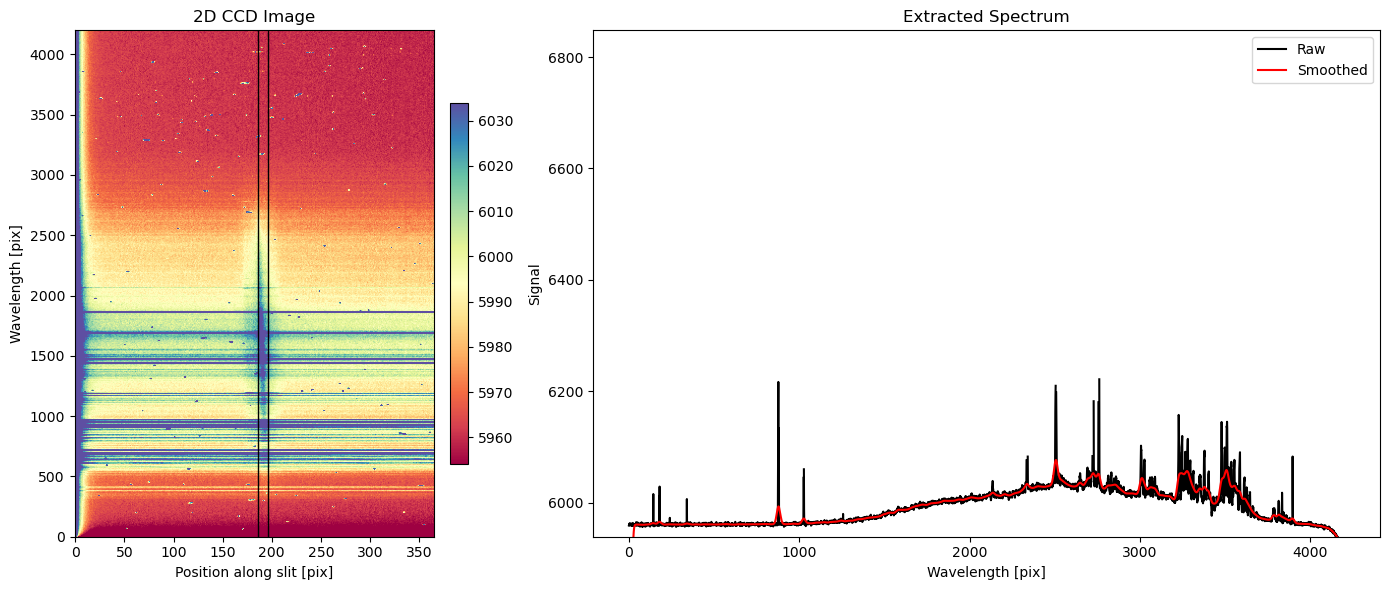

In [9]:
# Plot SB2
window = [3,13] 
plot_ccd_and_spectrum(data, window=window, axvlines_ccd = window)

### apply uncertainty

/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


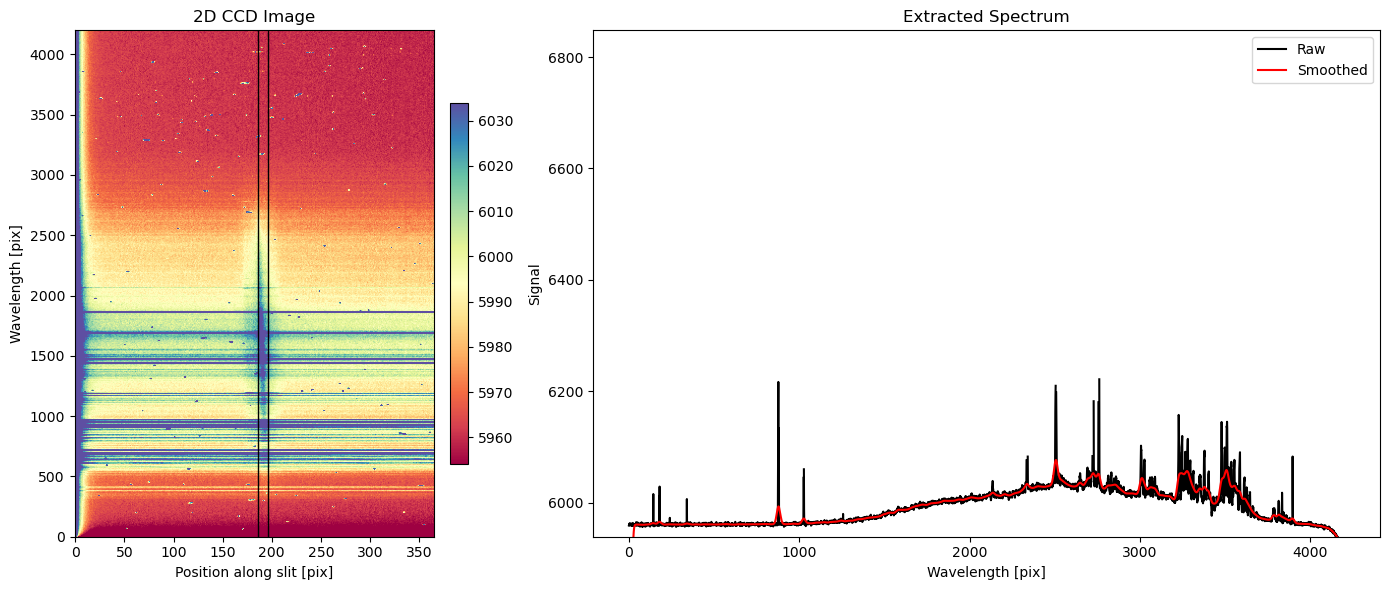

In [10]:
data = ccdproc.create_deviation(data, gain=gain * u.electron/u.adu, readnoise=readnoise * u.electron) 

plot_ccd_and_spectrum(data, window=window, axvlines_ccd = window)

### gain correction

/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


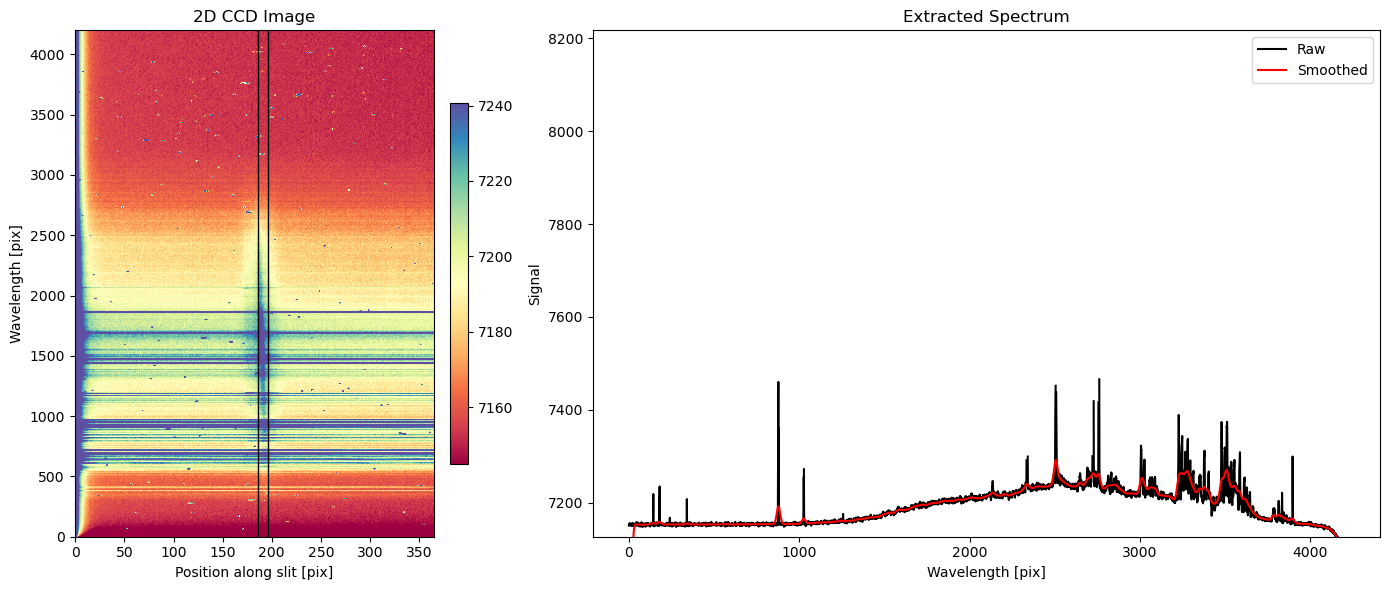

In [11]:
data = ccdproc.gain_correct(data, gain*u.electron/u.adu)
plot_ccd_and_spectrum(data, window=window, axvlines_ccd = window)

### subtract overscan

In [12]:
data = ccdproc.subtract_overscan(data, median=True,  overscan_axis=0, overscan=data[4110:4190,:])

/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


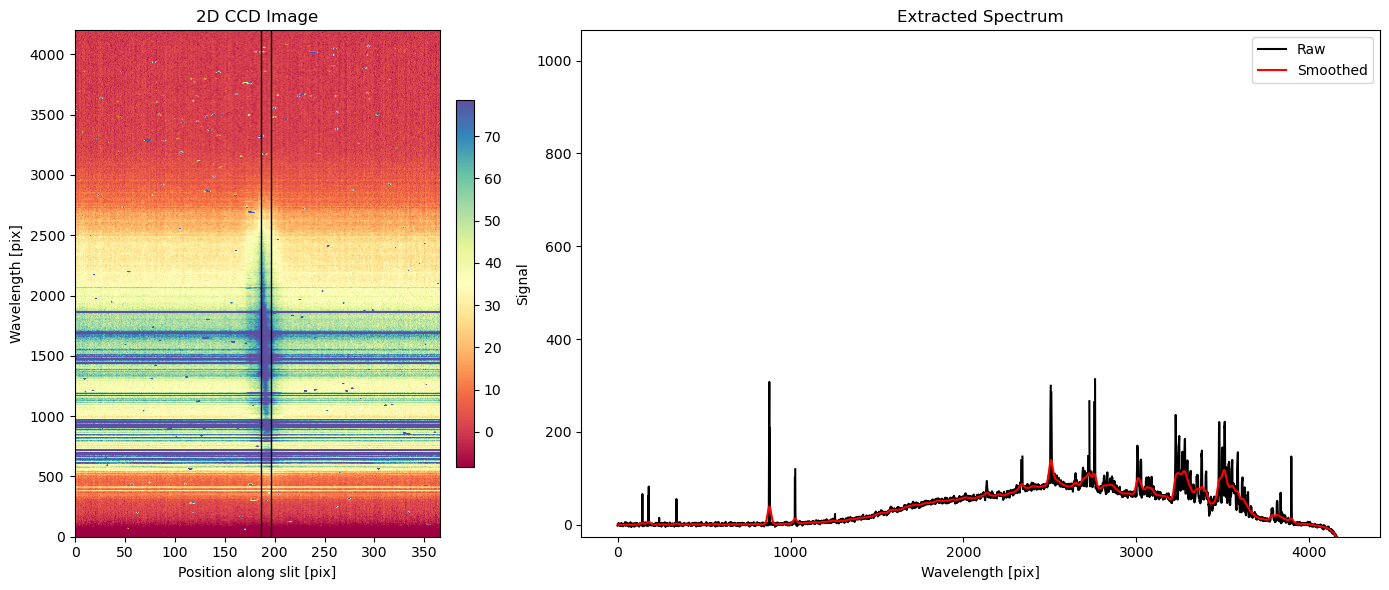

In [13]:
plot_ccd_and_spectrum(data, window=window, axvlines_ccd = window)

### bias subtraction

In [14]:
master_bias = CCDData(master_bias, unit=u.adu)
master_bias = ccdproc.gain_correct(master_bias, gain*u.electron/u.adu)
master_bias = ccdproc.subtract_overscan(master_bias, median=True,  overscan_axis=0, overscan=master_bias[4110:4190,:])

INFO:astropy:overwriting NDData's current unit with specified unit.


INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


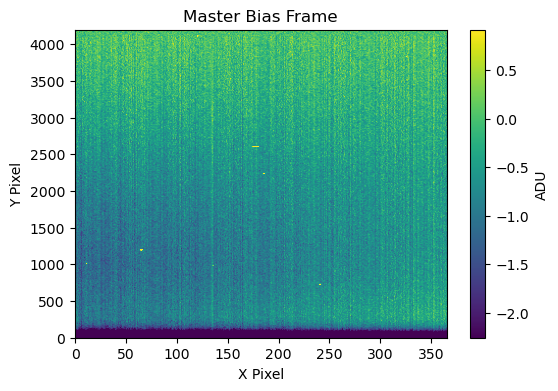

In [15]:
#check what the master bias looks like
plt.figure(figsize=(6,4))  
plt.imshow(master_bias.data, cmap='viridis', origin='lower',
           vmin=np.percentile(master_bias.data, 5),
           vmax=np.percentile(master_bias.data, 95),
           aspect='auto') 
plt.colorbar(label='ADU')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Master Bias Frame')
plt.show()


/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


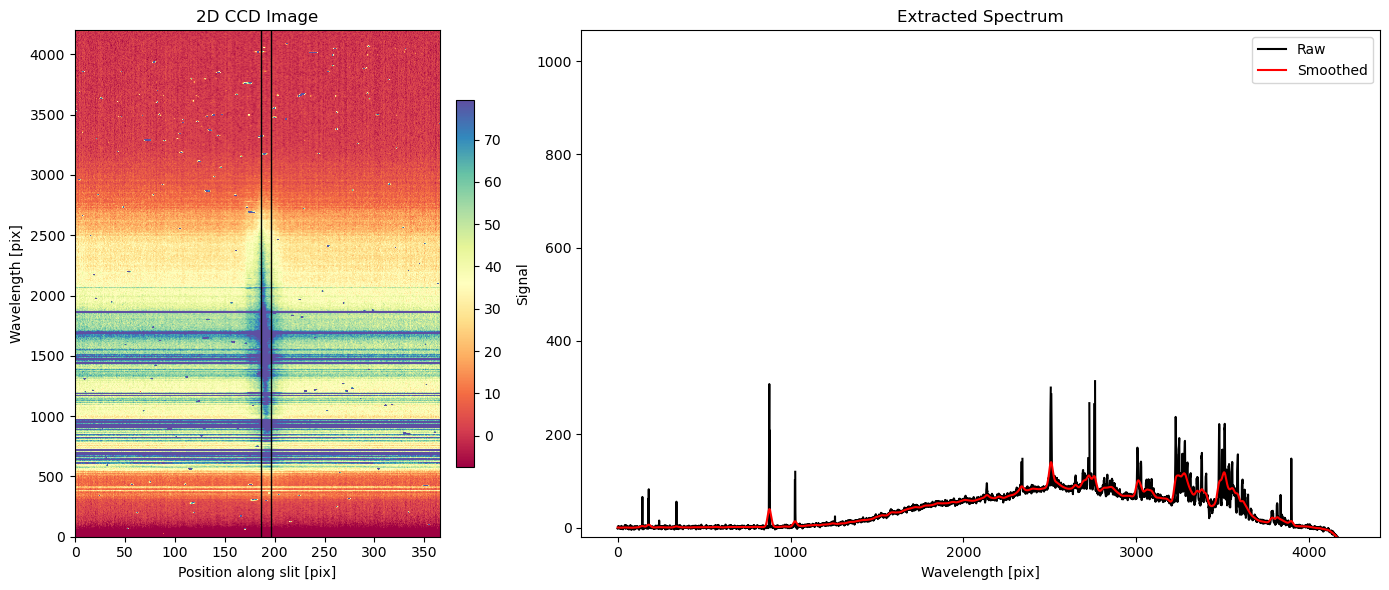

In [16]:
data_bg_subtracted = ccdproc.subtract_bias(data, master_bias)
plot_ccd_and_spectrum(data_bg_subtracted, window = window, axvlines_ccd = window)

### flatfield correction

In [17]:
master_flat = ccdproc.create_deviation(master_flat, gain=gain * u.electron/u.adu,readnoise = readnoise * u.electron)
master_flat = ccdproc.gain_correct(master_flat, gain*u.electron/u.adu)
master_flat = ccdproc.subtract_overscan(master_flat, median=True,  overscan_axis=0, overscan=master_flat[4110:4190,:])
master_flat = ccdproc.subtract_bias(master_flat, master_bias) 

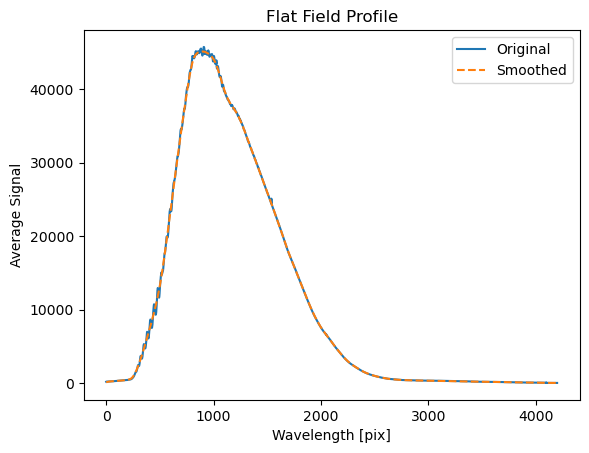

In [18]:
# Collapse the flat across the spatial direction
profile = np.mean(master_flat.data, axis=1)

# Smooth with Gaussian
smoothed = convolve(profile, Gaussian1DKernel(stddev=20))

# Plot
plt.plot(profile, label='Original')
plt.plot(smoothed, label='Smoothed', linestyle='--')
plt.xlabel('Wavelength [pix]')
plt.ylabel('Average Signal')
plt.title('Flat Field Profile')
plt.legend()
plt.show()


In [19]:
#Normalize the master flat
master_flat = ((np.array(master_flat).T / smoothed)).T
master_flat = CCDData(master_flat, unit=u.electron)

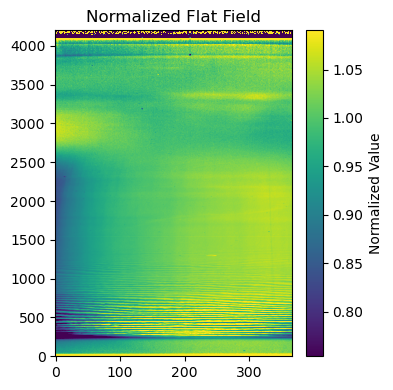

In [20]:
#Visualize the flat
plt.figure(figsize=(4, 4))
plt.imshow(master_flat.data, origin='lower', aspect='auto',
           vmin=np.percentile(master_flat.data, 2),
           vmax=np.percentile(master_flat.data, 95),
           cmap='viridis')
plt.colorbar(label='Normalized Value')
plt.title('Normalized Flat Field')
plt.tight_layout()
plt.show()


/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


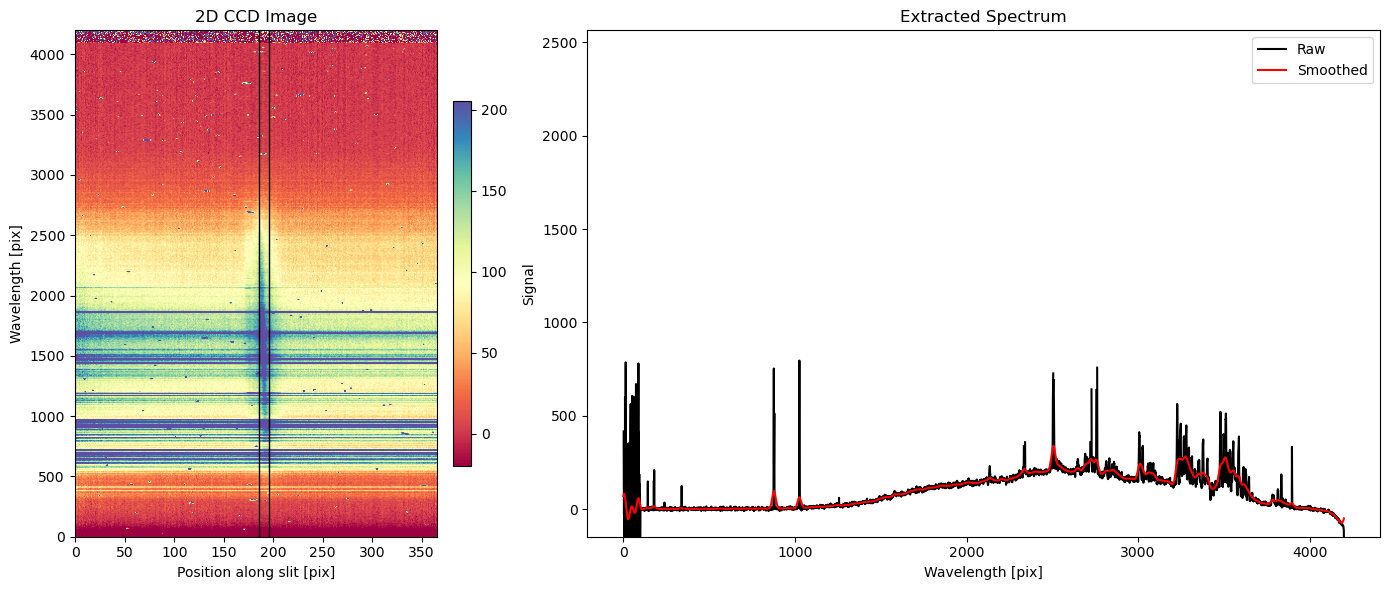

In [21]:
# Apply flatfield
data = ccdproc.flat_correct(data_bg_subtracted, master_flat, min_value=0.01)

plot_ccd_and_spectrum(data, window = window, axvlines_ccd = window)

### sky subtraction

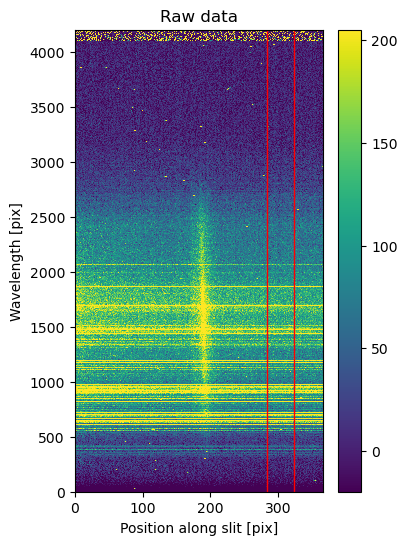

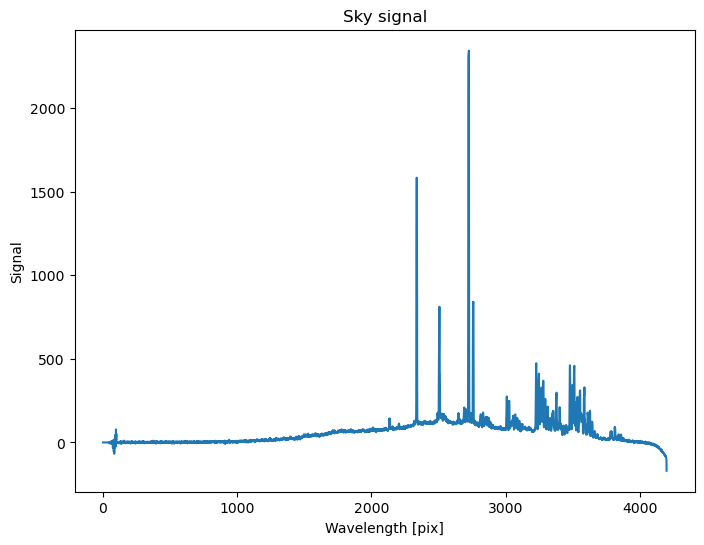

In [22]:
sky_window = [100,140] #selection window for sky subtraction

plot_ccd(data, axvlines = sky_window, figsize= (4,6))

lam,slit = data.shape
mid = slit/2
sky = data[:,int(mid+sky_window[0]):int(mid+sky_window[1])]
sky = np.median(sky,axis = 1)

plt.figure(figsize = (8,6))
plt.plot(range(len(sky))[::-1],sky)
plt.xlabel('Wavelength [pix]')
plt.ylabel('Signal')
plt.title('Sky signal')
plt.show()


/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


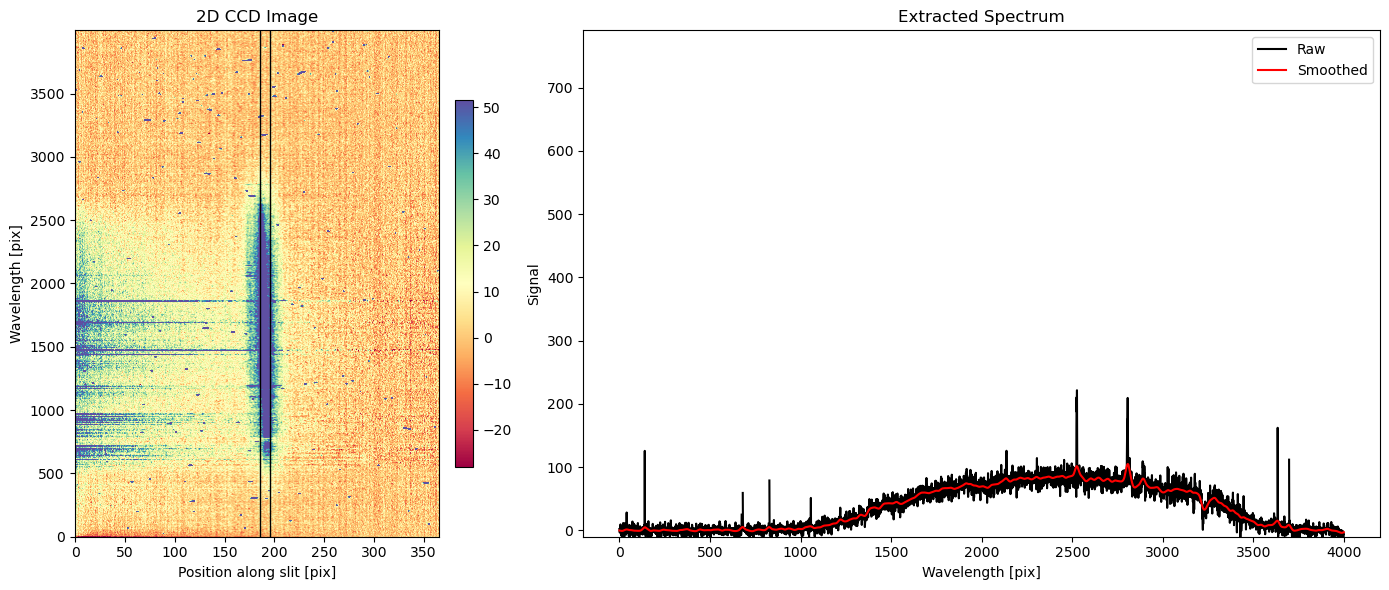

In [23]:
# Apply sky subtraction
data = np.array(data)[:4000, :] 
sky = sky[:4000]
data = (np.array(data).T - np.array(sky)).T
data = CCDData(data, unit=u.electron)

plot_ccd_and_spectrum(data, window = window, axvlines_ccd = window)


### apply arcs

In [24]:
master_bias = CCDData(master_bias.data[:4000, :], unit=master_bias.unit)

In [25]:
arc = ccdproc.create_deviation(arc, gain=gain * u.electron/u.adu,readnoise = readnoise * u.electron)
arc = ccdproc.gain_correct(arc, gain*u.electron/u.adu)
arc = ccdproc.subtract_overscan(arc, median=True,  overscan_axis=0, overscan=arc[4110:4190,:])
arc = ccdproc.trim_image(arc[:4000,:])
arc = ccdproc.subtract_bias(arc, master_bias) 

[-12.72857143  -2.7          2.18571429 ...   1.76285714   1.34571429
   0.27142857]


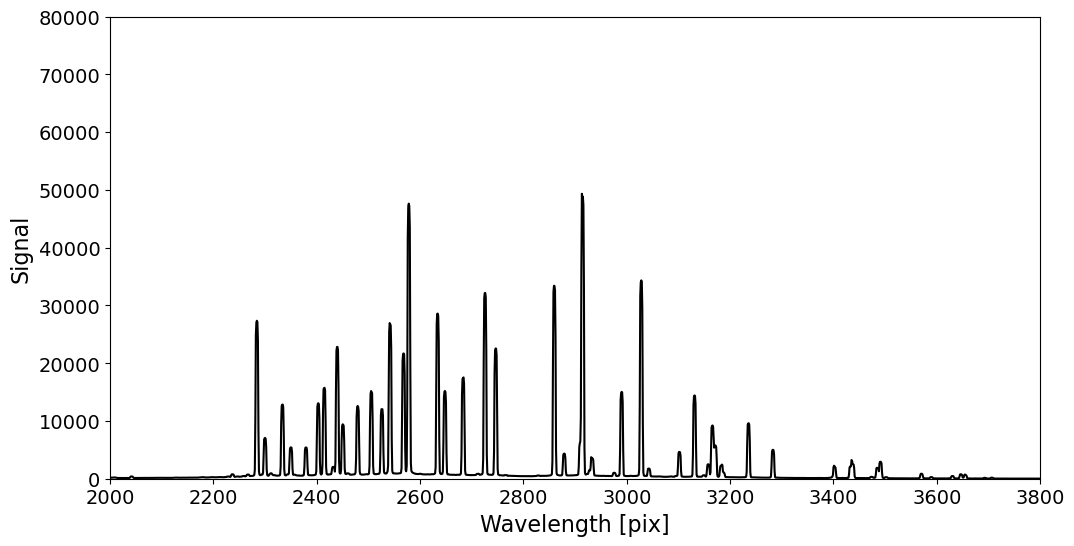

In [26]:
plot_estimated_spectrum(arc, window = window,ylims_override = [0,80000], 
                        plot_smooth = False, figsize = (12,6),
                       sigma_clipping = False, xlims_override=(2000, 3800))

In [27]:
from scipy.signal import find_peaks
arc_spectrum = extract_spectrum(arc, window)
peaks, _ = find_peaks(arc_spectrum, height=8000, distance = 15)

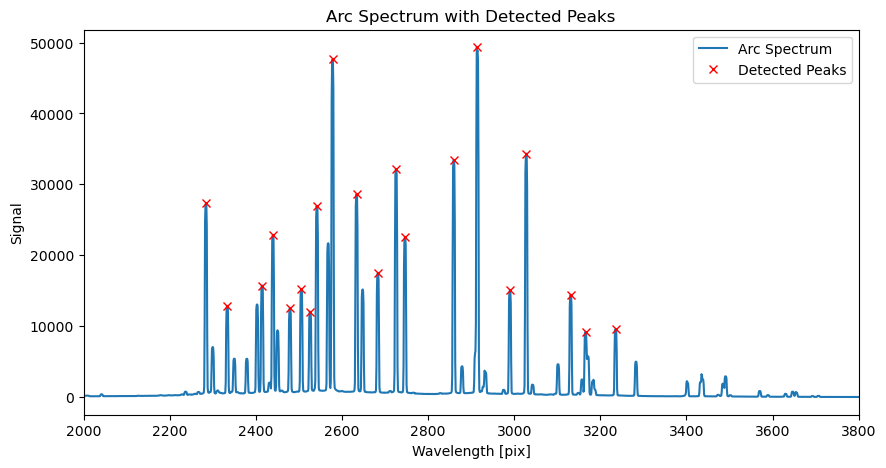

In [28]:
plt.figure(figsize=(10,5))
xaxis = np.array(range(len(arc_spectrum)))[::-1]

plt.plot(xaxis, arc_spectrum, label='Arc Spectrum')
plt.plot(xaxis[peaks], arc_spectrum[peaks], 'rx', label='Detected Peaks')
plt.xlabel('Wavelength [pix]')
plt.ylabel('Signal')
plt.title('Arc Spectrum with Detected Peaks')
plt.xlim(2000,3800)
plt.legend()
plt.show()


In [29]:
def centroid(x, I):
    value= np.sum(x*I)/np.sum(I)
    return value 

In [30]:
# Define window range
ranges = 8

# Compute centroids
centroids = []
for i in range(len(peaks)):
    left = max(peaks[i] - ranges, 0)
    right = min(peaks[i] + ranges + 1, len(arc_spectrum))
    window_x = xaxis[left:right]
    window_y = arc_spectrum[left:right]
    
    # Calculate centroid as weighted average
    centroid = np.sum(window_x * window_y) / np.sum(window_y)
    centroids.append(centroid)

print("Centroid positions:", centroids)

Centroid positions: [3235.53337423859, 3167.0310023788315, 3131.0422708829983, 3027.9136745242336, 2989.9715102147293, 2914.0362139704926, 2859.591365352606, 2746.217652992624, 2725.575821036441, 2683.280754270887, 2633.828970366144, 2577.499777425987, 2541.7174971235554, 2526.013813244241, 2505.436856059334, 2479.1210095692295, 2439.785649923404, 2414.4852173283193, 2333.504158243432, 2283.964056635374]


[-12.72857143  -2.7          2.18571429 ...   1.76285714   1.34571429
   0.27142857]


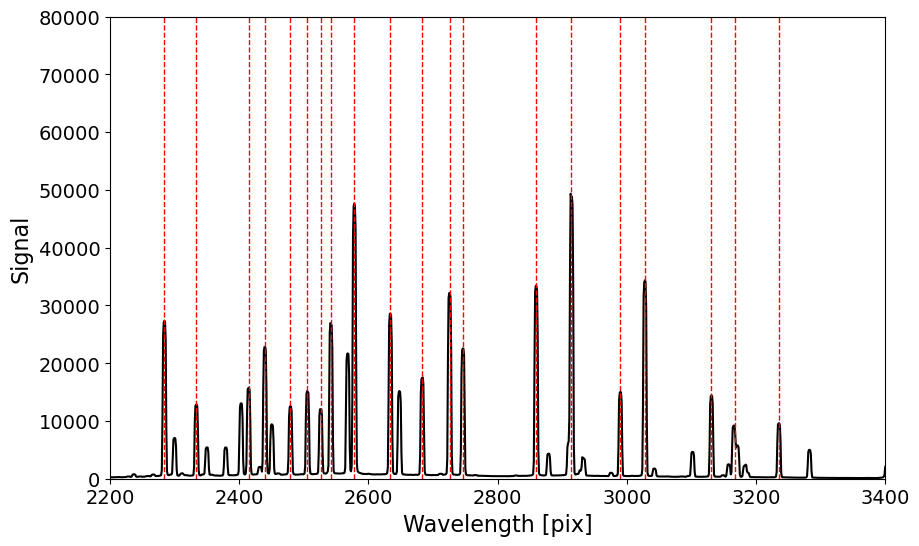

In [31]:
plot_estimated_spectrum(arc, window = window,ylims_override = [0,80000], 
                        plot_smooth = False, figsize = (10,6),
                       sigma_clipping = False, xlims_override=(2200, 3400), axvlines = centroids)

In [32]:
len(centroids)

20

20
Slope: 1.87282 Å/pixel
Intercept: 1574.27482 Å


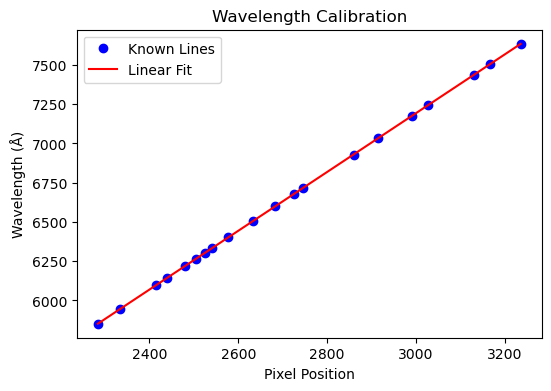

In [33]:
# Known emission lines
emissions = np.array([5852.49, 5944.83, 6096.16, 6143.06, 
                      6217.28, 6266.50, 6304.79, 6334.43, 6402.25, 6506.53,
                      6598.95, 6678.28, 6717.04, 6929.47, 7032.41, 
                      7173.94, 7245.17, 7438.90, 7503.87, 7635.11])

print(len(emissions))
# Measured pixel centroids
centroids = np.array(sorted(centroids))  

# Fit a line (degree=1)
coeffs = np.polyfit(centroids, emissions, 1)
slope, intercept = coeffs

print(f"Slope: {slope:.5f} Å/pixel")
print(f"Intercept: {intercept:.5f} Å")

# Evaluate the fit
fitted_wavelengths = slope * centroids + intercept

# Plotting
plt.figure(figsize=(6,4))
plt.plot(centroids, emissions, 'bo', label='Known Lines')
plt.plot(centroids, fitted_wavelengths, 'r-', label='Linear Fit')
plt.xlabel('Pixel Position')
plt.ylabel('Wavelength (Å)')
plt.title('Wavelength Calibration')
plt.legend()
plt.show()


In [34]:
# Pixels for the spectrum
pixels = np.arange(len(arc_spectrum))[::-1]

# Apply the linear calibration
xaxis_waveobs = slope * pixels + intercept

[-18.36570813  -5.64550268  -6.68854431 ...  -3.43493041   0.13105203
   2.27617164]


/var/folders/r3/l94405xd0mq2s62v2swzjq2m0000gn/T/ipykernel_33276/3845173355.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if xaxis == []:


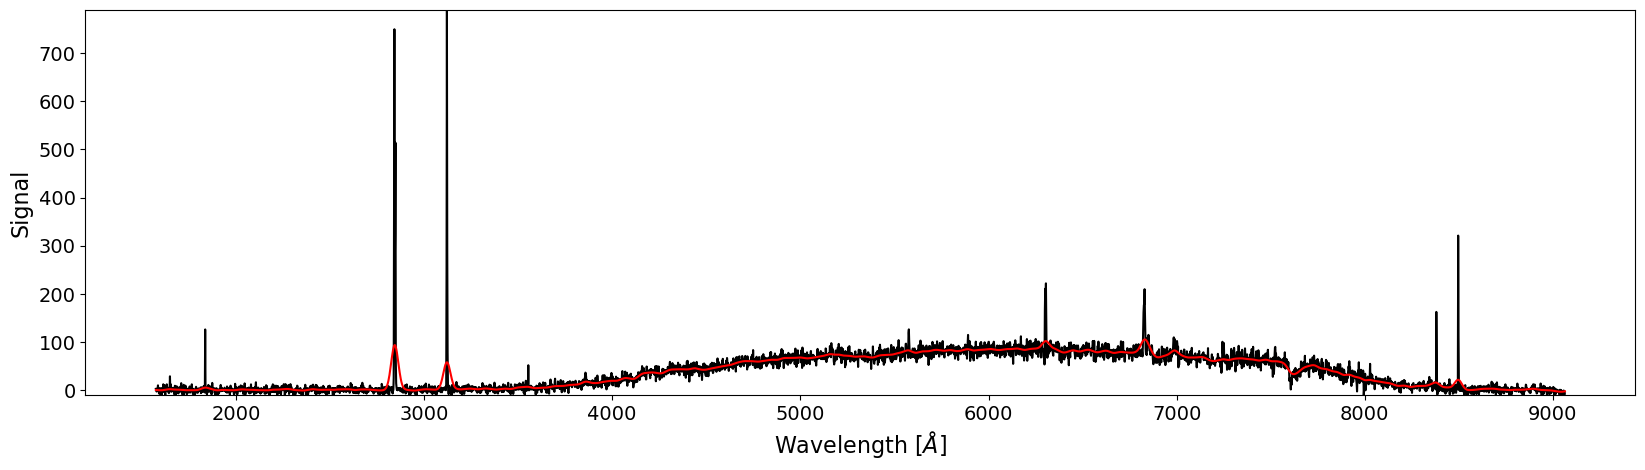

In [35]:
spectrum = extract_spectrum(data,window)

plot_estimated_spectrum(spectrum, window = window, xaxis = xaxis_waveobs,
                        figsize = (20,5), xlab = r'Wavelength [$\AA$]', ylab = r'Signal',
                        sigma_clipping = 10, stdev = 10)

### flux calibration

In [36]:
#apply pipeline to standard 
standard = ccdproc.create_deviation(standard, gain=gain * u.electron/u.adu,readnoise = readnoise * u.electron)
standard = ccdproc.gain_correct(standard, gain*u.electron/u.adu)
standard = ccdproc.subtract_overscan(standard, median=True,  overscan_axis=0, overscan=standard[4110:4190,:])
standard = ccdproc.trim_image(standard[:4000,:])
master_flat = CCDData(master_flat.data[:4000, :], unit=master_flat.unit)

standard = ccdproc.subtract_bias(standard, master_bias) 
standard = ccdproc.flat_correct(standard, master_flat, min_value=0.01)

# Sky subtraction
sky_window = [100,140] #selection window for sky subtraction
lam,slit = standard.shape
mid = slit/2
sky = standard[:,int(mid+sky_window[0]):int(mid+sky_window[1])]
sky = np.median(sky,axis = 1)
standard = (np.array(standard).T - np.array(sky)).T
standard = CCDData(standard, unit=u.electron)


/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


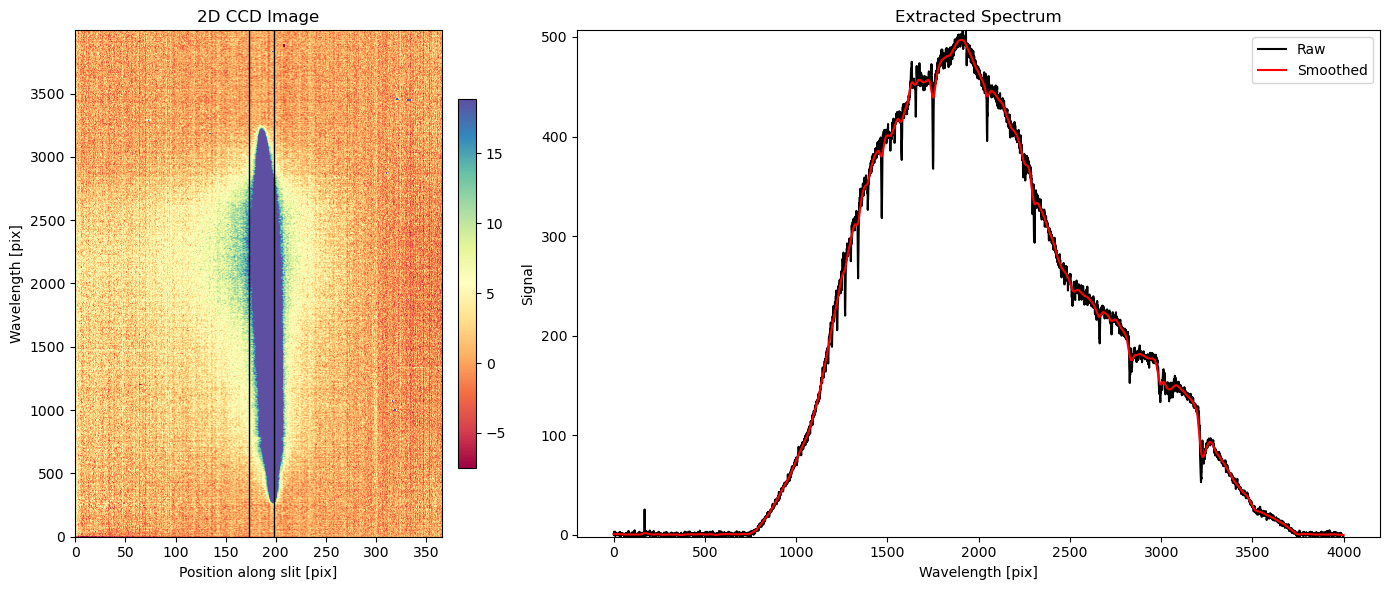

In [37]:
standard_window = [-10,15]
plot_ccd_and_spectrum(standard, standard_window, axvlines_ccd = standard_window)

[-5.1150614  -2.04753798 -0.89994291 ...  2.76021688 -0.46529371
  0.44524312]


/var/folders/r3/l94405xd0mq2s62v2swzjq2m0000gn/T/ipykernel_33276/3845173355.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if xaxis == []:


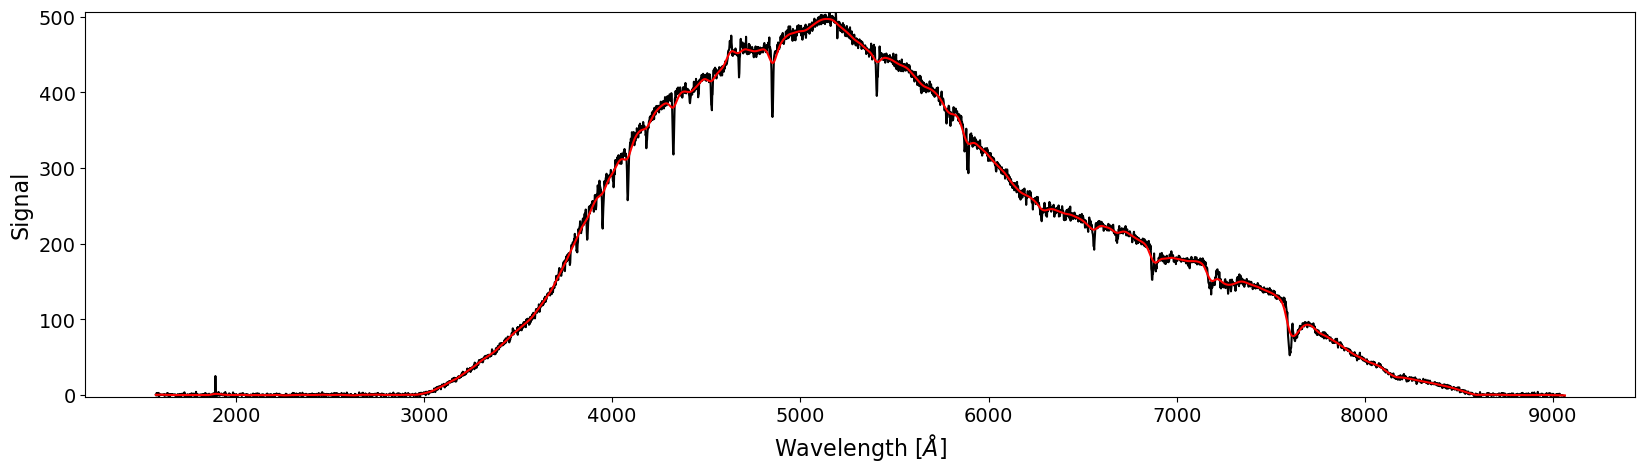

In [38]:
standard_spectrum = extract_spectrum(standard,standard_window)


plot_estimated_spectrum(standard_spectrum, window = window, xaxis = xaxis_waveobs, 
                        figsize = (20,5), xlab = r'Wavelength [$\AA$]', ylab = r'Signal',
                        sigma_clipping = 10, stdev = 10)

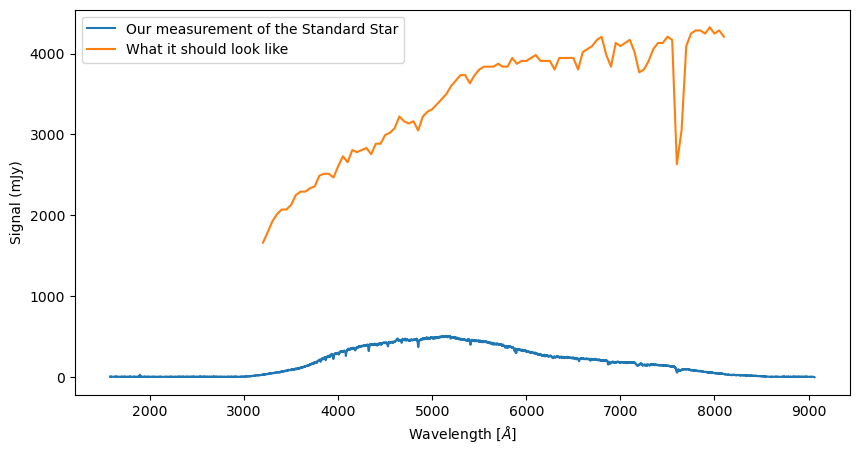

In [39]:
#plot the observed vs expected spectra
#multiply to double check
plt.figure(figsize = (10,5))
plt.plot(xaxis_waveobs, standard_spectrum, label = 'Our measurement of the Standard Star')
plt.plot(wavelengths, flux_mJy, label = 'What it should look like')

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Signal (mJy)')
plt.legend()
plt.show()


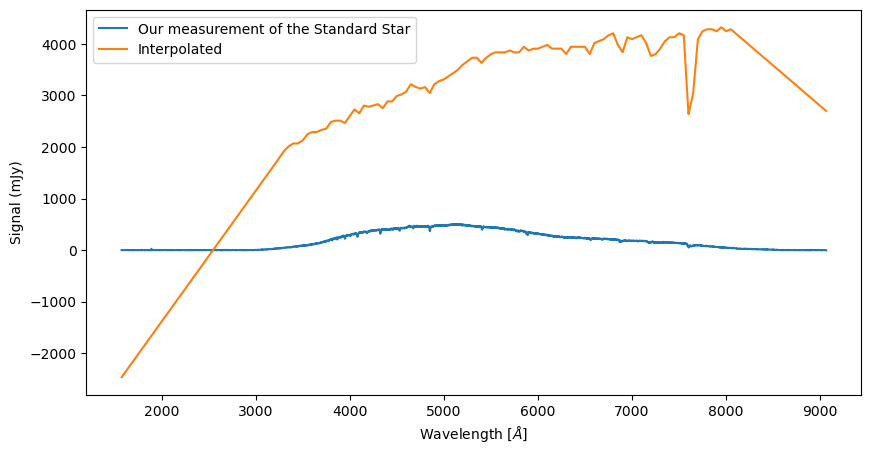

In [40]:
#interpolate so we have the same x-axis
interp_flux = interp1d(wavelengths, flux_mJy, kind='linear', bounds_error=False, fill_value="extrapolate")
flux_mJy_interp = interp_flux(xaxis_waveobs)


plt.figure(figsize = (10,5))
plt.plot(xaxis_waveobs, standard_spectrum, label = 'Our measurement of the Standard Star')
#plt.plot(wavelengths, flux_mJy, label = 'What it should look like')
plt.plot(xaxis_waveobs, flux_mJy_interp, label = 'Interpolated')

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Signal (mJy)')
plt.legend()
plt.show()


In [41]:
# Create a smoothened version of the interpolated INT's version of the standard star
stddev_standard_star = 80 #DEPENDS ON RESOLTION. SO ADJUST THIS AS NEEDED.
gauss = Gaussian1DKernel(stddev=stddev_standard_star)
smooth_standard_int = convolve(flux_mJy_interp, gauss, boundary = 'extend')

##maybe try a spline fit, or median window? 
# Create a smoothened version of our standard star
gauss = Gaussian1DKernel(stddev=stddev_standard_star)
smooth_standard_our = convolve(standard_spectrum, gauss, boundary = 'extend')

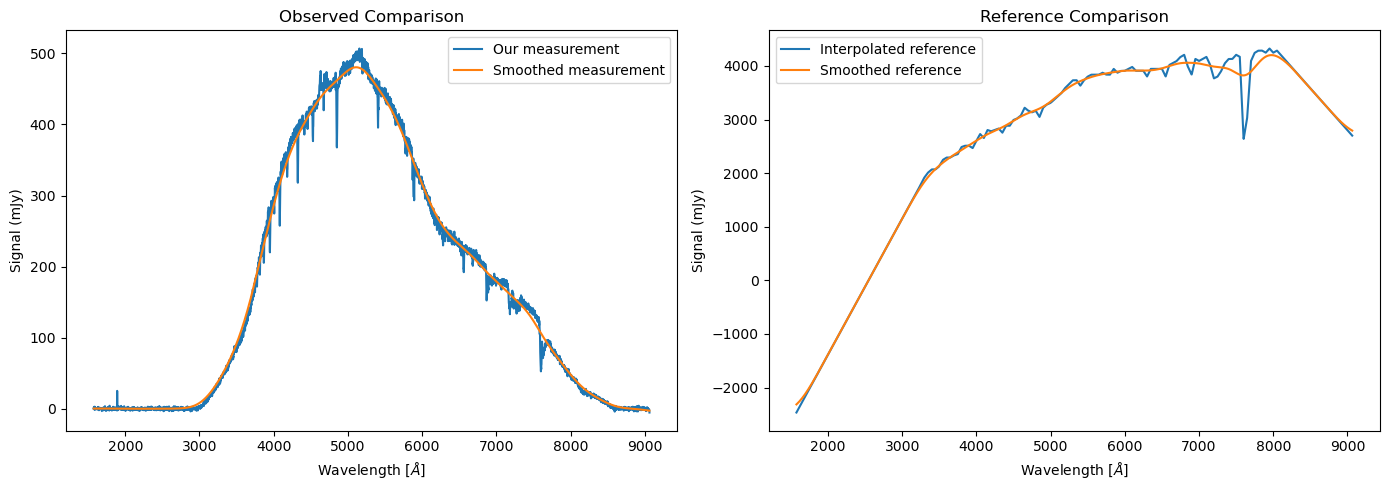

In [42]:
plt.figure(figsize=(14, 5))

# Left plot: Raw and interpolated standard
plt.subplot(1, 2, 1)
plt.plot(xaxis_waveobs, standard_spectrum, label='Our measurement')
plt.plot(xaxis_waveobs, smooth_standard_our, label='Smoothed measurement')

plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Signal (mJy)')
plt.title('Observed Comparison')
plt.legend()

# Right plot: Smooth versions
plt.subplot(1, 2, 2)
plt.plot(xaxis_waveobs, flux_mJy_interp, label='Interpolated reference')
plt.plot(xaxis_waveobs, smooth_standard_int, label='Smoothed reference')


plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Signal (mJy)')
plt.title('Reference Comparison')
plt.legend()

plt.tight_layout()
plt.show()

# LOOK OUT FOR the lines of the standard stars. They should overlap quite well.

In [43]:
response_curve = smooth_standard_int / (smooth_standard_our)

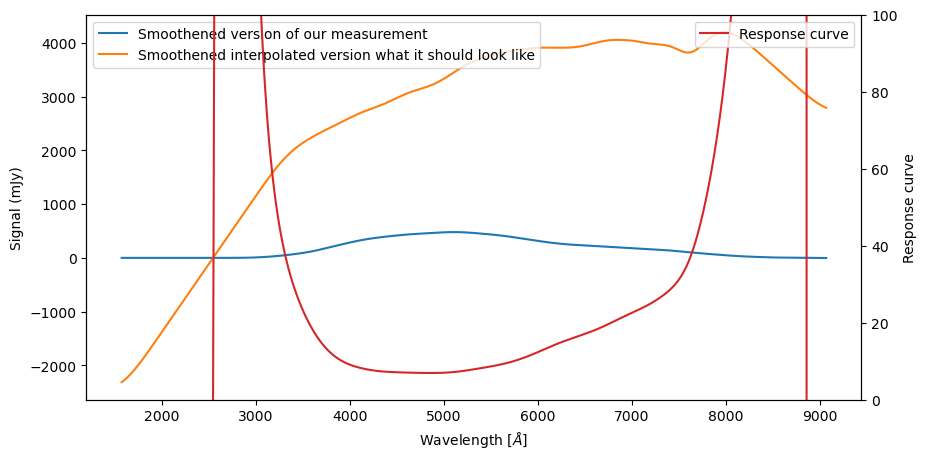

In [44]:
plt.figure(figsize = (10,5))

plt.plot(xaxis_waveobs,smooth_standard_our, label ='Smoothened version of our measurement')
plt.plot(xaxis_waveobs,smooth_standard_int, label = 'Smoothened interpolated version what it should look like')
plt.legend(loc='upper left')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Signal (mJy)')

#plt.ylim(0,300) #Adjust this as needed

ax = plt.gca().twinx()
ax.plot(xaxis_waveobs, response_curve, c = 'C3', label = 'Response curve')
ax.set_ylabel('Response curve')
plt.legend(loc = 'upper right')
plt.ylim(0,100)
plt.show()

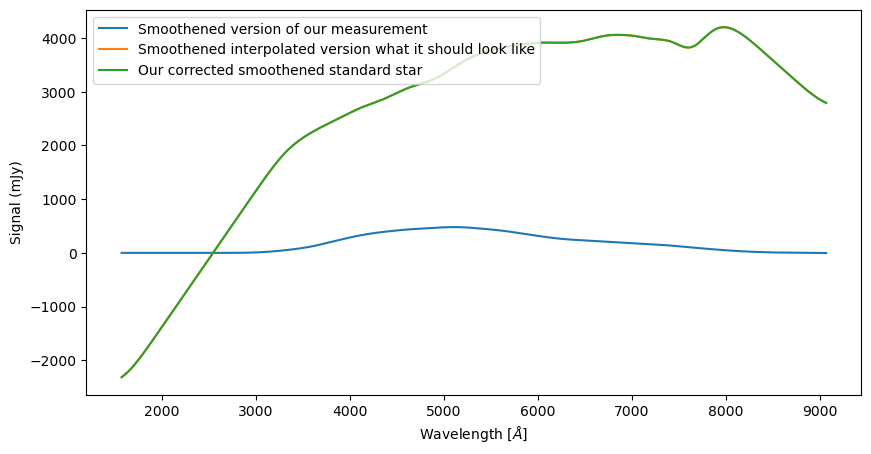

In [45]:
# apply correction to smoothed standard star observation

corrected = smooth_standard_our*response_curve * exposure_time_standard/exposure_time_standard
# NOTE: We're just multiplying by the response curve, and scaling by exposure time. Since we're applying this on the 
# standard star, the exposure time ratio = 1. 

# NOTE 2: Because we're applying this on the standard star, we're ignoring the atmospheric extinction, since the 
# airmass should be identical. This will change below, though, when applying the response curve on the science image

plt.figure(figsize = (10,5))
plt.plot(xaxis_waveobs,smooth_standard_our, label ='Smoothened version of our measurement')
plt.plot(xaxis_waveobs,smooth_standard_int, label = 'Smoothened interpolated version what it should look like')
plt.plot(xaxis_waveobs,corrected, label ='Our corrected smoothened standard star')

#plt.ylim(0,300) 
plt.legend(loc='upper left')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Signal (mJy)')
plt.show()


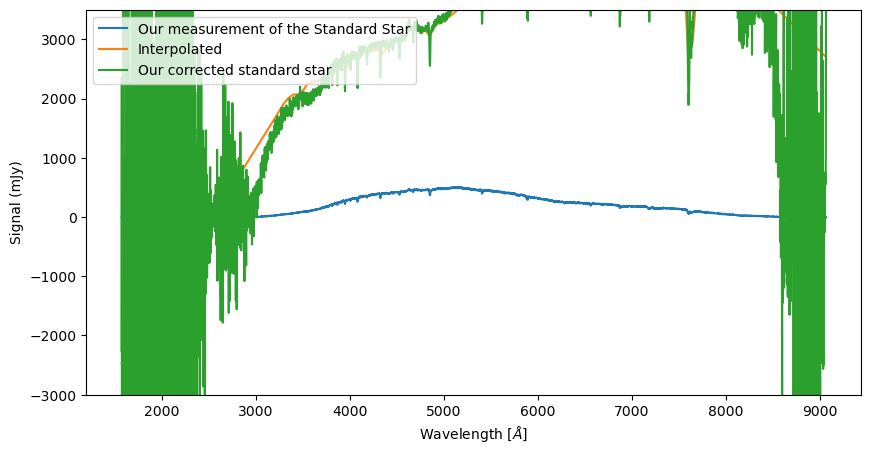

In [46]:
# apply to the unsmoothed version of the standard star observation

corrected = standard_spectrum*response_curve * exposure_time_standard/exposure_time_standard

plt.figure(figsize = (10,5))
plt.plot(xaxis_waveobs,standard_spectrum, label = 'Our measurement of the Standard Star')
plt.plot(xaxis_waveobs, flux_mJy_interp, label = 'Interpolated')
#plt.plot(wavelengths, flux_mJy, label = 'What it should look like')
plt.plot(xaxis_waveobs,corrected, label ='Our corrected standard star')

plt.ylim(-3000,3500)
plt.legend(loc='upper left')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Signal (mJy)')
plt.show()

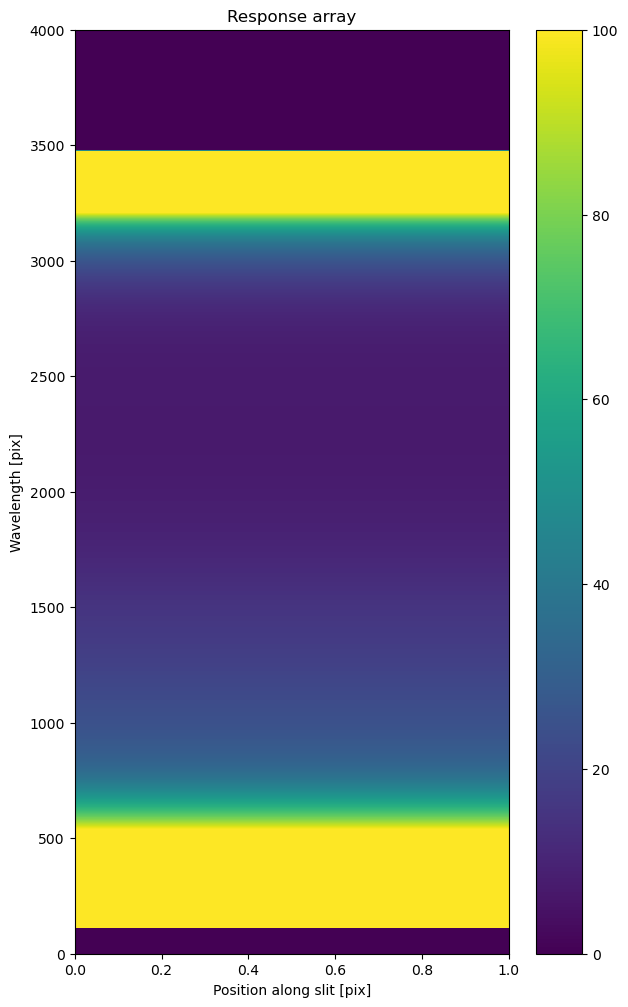

In [47]:
response_array = np.array(response_curve)[:, np.newaxis]

plot_ccd(response_array, vmin = 0, vmax = 100, title = 'Response array')

In [48]:
data_prefluxcal = data.copy()

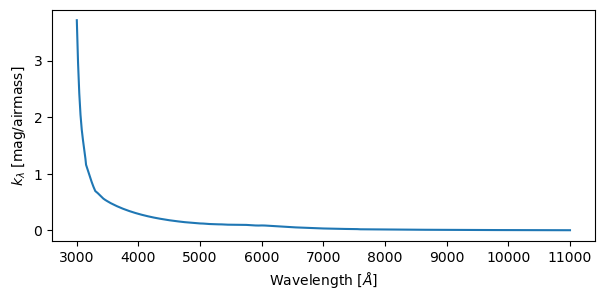

In [49]:
#Plot extinction curve
extinction_path = '/Users/owner1/Documents/extinction.tex'
ext_df = pd.read_csv(extinction_path, delim_whitespace=True, header=None)
ext_df.columns = ['wavelength', 'ext']

plt.figure(figsize = (7,3))
plt.plot(ext_df['wavelength'],ext_df['ext'])
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('$k_{\lambda}$ [mag/airmass]')
plt.show()


f_ext = interp1d(ext_df['wavelength'],ext_df['ext'], bounds_error = False, fill_value = (np.nan,np.nan))

# We can now use f_ext as follows to get the k_lambda at any wavelength
#k_lambda = f_ext(wavelength)

In [50]:
#apply flux calibration + airmass differences + exposure time differences 

#Compute extinction correction (1D)
extinction_ratio = 10**(0.4 * f_ext(xaxis_waveobs) * (airmass_science - airmass_standard))  # shape: (4000,)

#Expand to 2D to match data shape
extinction_ratio_2d = np.repeat(extinction_ratio[:, np.newaxis], data.shape[1], axis=1)  # shape: (4000, 366)

#Apply calibration 
data = data * response_array * extinction_ratio_2d * (exposure_time_standard / exposure_time_science)


/var/folders/r3/l94405xd0mq2s62v2swzjq2m0000gn/T/ipykernel_33276/3845173355.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if xaxis == []:


[624.38053569 194.13697234 232.67968074 ...          nan          nan
          nan]


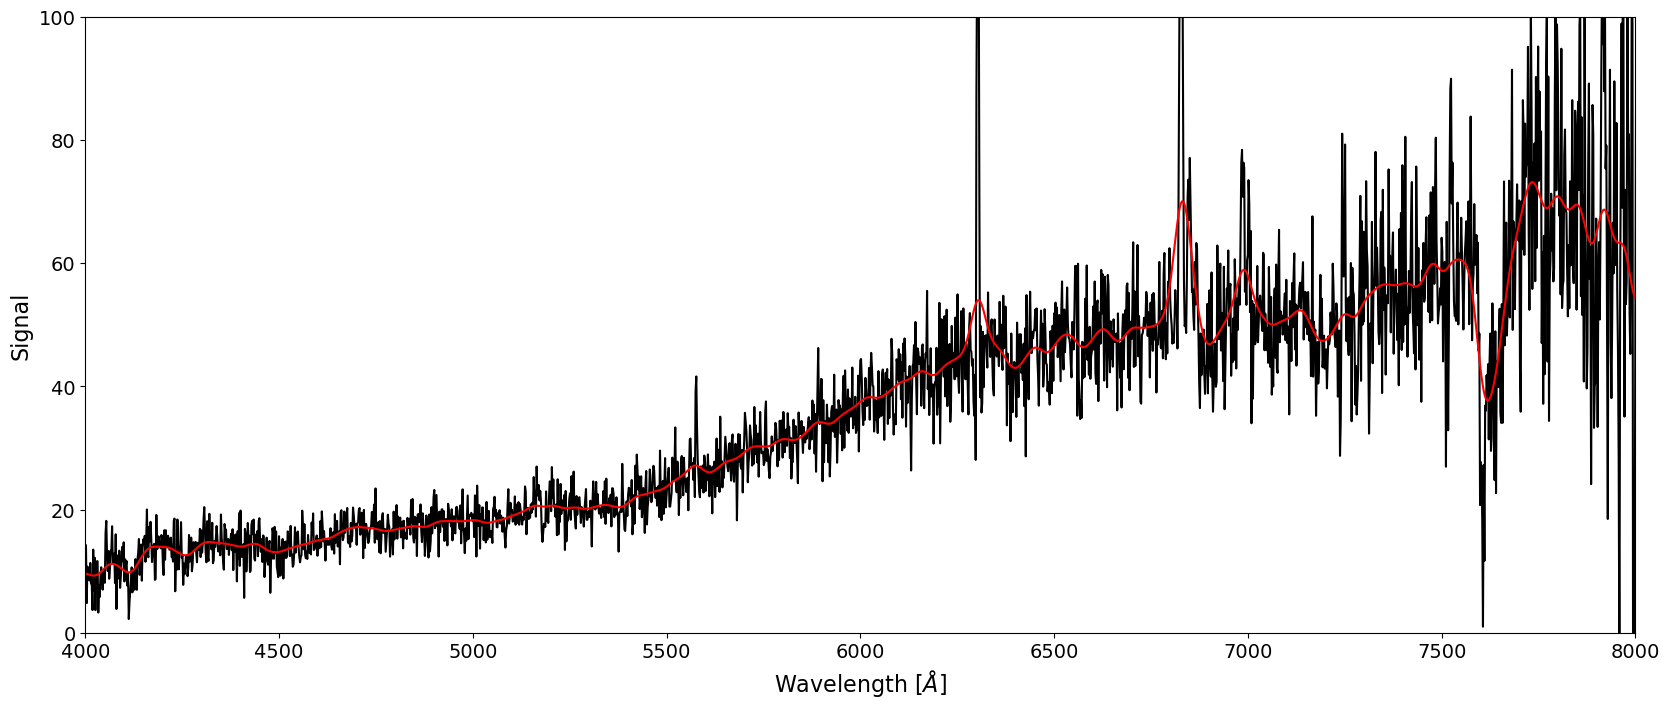

In [51]:
plot_estimated_spectrum(data, window = window, ylims_override = [0,100], 
                        xaxis = xaxis_waveobs, xlims_override = [4000,8000],
                        figsize = (20,8), xlab = r'Wavelength [$\AA$]', ylab = r'Signal')

### Redshift Correction

In [52]:
data = data[1000:3000, :]
xaxis_waveem =  xaxis_waveobs / (1 + redshift)
xaxis_waveem = xaxis_waveem[1000:3000]

/var/folders/r3/l94405xd0mq2s62v2swzjq2m0000gn/T/ipykernel_33276/3845173355.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if xaxis == []:


[ 54.21399447  47.66964945  58.09869407 ...  11.29130703 -10.30742514
  37.5159338 ]


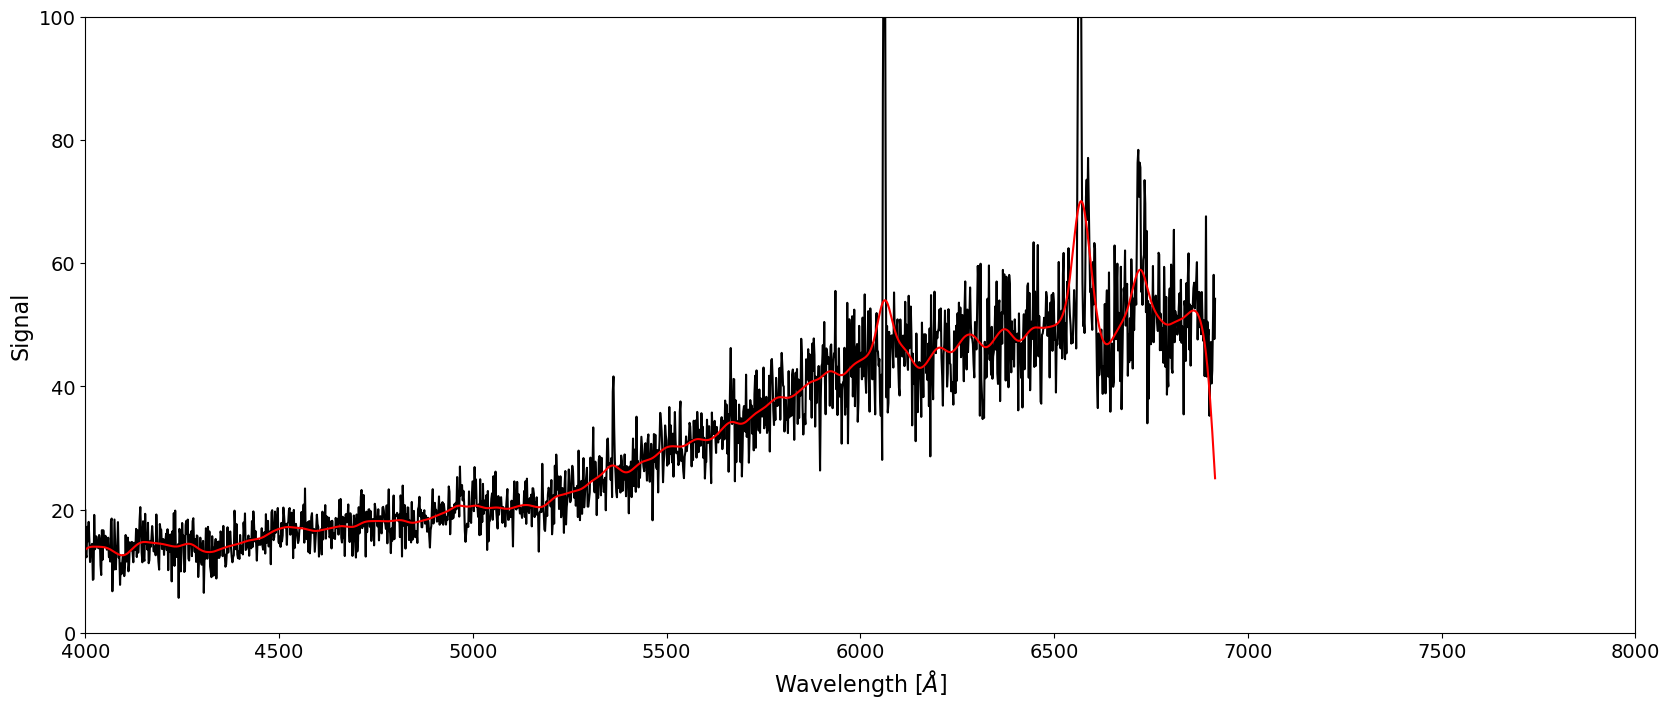

In [53]:
plot_estimated_spectrum(data, window = window, ylims_override = [0,100], 
                        xaxis = xaxis_waveem, xlims_override = [4000,8000],
                        figsize = (20,8), xlab = r'Wavelength [$\AA$]', ylab = r'Signal')

### save the data

In [54]:
np.save("calibrated data/WB7_data_orth.npy", data)
np.save("calibrated data/WB7_waveem_orth.npy", xaxis_waveem)